In [20]:
# TSLA Model Comparison: LSTM, CNN-LSTM, TCN, GRU, Transformer, Linear Regression
import pandas as pd
import numpy as np
import yfinance as yf
import os
import datetime
import mplfinance as mpf
import matplotlib.pyplot as plt
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [31]:
# Helper functions for loading finance data, FRED data, creating time features, and calculating technical indicators and flattening columns
def load_finance_data(ticker):
    data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    data[f'{ticker}_Returns'] = data['Close'].pct_change().fillna(0)
    return data

def load_fred_data(series_id, name):
    data = fred.get_series(series_id, observation_start='2010-01-01', observation_end='2024-12-31')
    data = pd.DataFrame(data, columns=[name]).dropna()
    data.index = pd.to_datetime(data.index)
    return data.resample('D').ffill()

def add_time_features(df, prefix=''):
    df[f'{prefix}hour'] = df.index.hour
    df[f'{prefix}day'] = df.index.day
    df[f'{prefix}month'] = df.index.month
    df[f'{prefix}weekday'] = df.index.weekday
    df[f'{prefix}is_weekend'] = df[f'{prefix}weekday'].apply(lambda x: 1 if x >= 5 else 0)
    return df

def calculate_technical_indicators(df, ticker):
    df[f'{ticker}_RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean()))
    df[f'{ticker}_EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df[f'{ticker}_EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df[f'{ticker}_MACD'] = df[f'{ticker}_EMA_12'] - df[f'{ticker}_EMA_26']
    return df

def flatten_cols(df):
    df.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df.columns]
    return df
   
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Preparing the data for modeling
def prepare_train_val_test(combined_data, seq_length=SEQ_LENGTH):
    # Sort by date to maintain chronological order
    combined_data.sort_values(by='Date', inplace=True)

    # Use only the columns that end with 'Close_Scaled' for prediction
    close_scaled_col = [col for col in combined_data.columns if col.lower().endswith('close_scaled')][0]
    close_prices = combined_data[close_scaled_col].values

    # Create sequences and labels
    X, y = create_sequences(close_prices, seq_length)

    # Split data into training (70%), validation (15%), and testing (15%)
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    # Reshape for DL models
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_val, X_test, y_train, y_val, y_test

In [32]:
# Data Import and Preprocessing

stocks = ['TSLA', 'BTC-USD', 'BZ=F', 'DX-Y.NYB', '%5EVIX', '%5EGSPC']
pce_series = {'PCEPI': 'PCE_Price_Index', 'PCEPILFE': 'Core_PCE_Price_Index'}
all_data = {}
scaler = MinMaxScaler()

# Initialize FRED API
FRED_API_KEY = '92300a5052e3ca2facec21726fc18b04'
fred = Fred(api_key=FRED_API_KEY)

# Load stock data
for ticker in stocks:
    df = load_finance_data(ticker)
    df = add_time_features(df, prefix=f'{ticker}_')
    df = calculate_technical_indicators(df, ticker)
    df[f'{ticker}_Close_Scaled'] = scaler.fit_transform(df[['Close']])
    all_data[ticker] = df

# Load FRED macro data
for series_id, name in pce_series.items():
    df = load_fred_data(series_id, name)
    all_data[name] = df

# Merge all sources
combined_data = None
first = True
for name, df in all_data.items():
    df = flatten_cols(df)
    if first:
        combined_data = df
        first = False
    else:
        combined_data = pd.merge(combined_data, df, left_index=True, right_index=True, how='outer')

combined_data.reset_index(inplace=True)

# Detect index column and rename to Date
possible_date_cols = [col for col in combined_data.columns if 'date' in col.lower() or col.lower() == 'index']
if possible_date_cols:
    combined_data.rename(columns={possible_date_cols[0]: 'Date'}, inplace=True)
else:
    raise ValueError("Could not find a date or index column after reset_index.")
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.set_index('Date', inplace=True)

# Flatten again and clean column names
combined_data.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in combined_data.columns]
combined_data.columns = [col.replace('P_C_E___P_r_i_c_e___I_n_d_e_x', 'PCE_Price_Index')
                                 .replace('C_o_r_e___P_C_E___P_r_i_c_e___I_n_d_e_x', 'Core_PCE_Price_Index')
                                 for col in combined_data.columns]

# Drop NA to align input
combined_data = combined_data.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [33]:
# Prepare the training, validation, and testing datasets
X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test(combined_data)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1768, 30, 1), y_train shape: (1768,)
X_val shape: (379, 30, 1), y_val shape: (379,)
X_test shape: (380, 30, 1), y_test shape: (380,)


In [34]:
# Linear Regression

# Recreate full X and y before split for Linear Regression
X_all, y_all = create_sequences(close_prices, SEQ_LENGTH)

X_lr = X_all.reshape((X_all.shape[0], X_all.shape[1]))
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_all, test_size=0.2, shuffle=False)

lr_model = LinearRegression().fit(X_train_lr, y_train_lr)
y_pred_lr = lr_model.predict(X_test_lr)

In [35]:
# LSTM	Model

# Sequence length for LSTM (e.g., use the past 30 days to predict the next day)
SEQ_LENGTH = 30

# Get the same Close_Scaled column again
close_scaled_col = [col for col in combined_data.columns if col.lower().endswith('close_scaled')][0]
close_prices = combined_data[close_scaled_col].values

# LSTM
lstm_model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
print(lstm_model.summary())

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

None


In [36]:
# TCN
tcn_model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    Conv1D(64, 2, dilation_rate=1, activation='relu'),
    BatchNormalization(),
    Conv1D(64, 2, dilation_rate=2, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
tcn_model.compile(optimizer='adam', loss='mse')
tcn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
print(tcn_model.summary())

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 29, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 29, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 27, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 27, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │        86,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,873 (1.09 MB)

 Trainable params: 95,205 (371.89 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 190,412 (743.80 KB)

None


In [37]:
# Simple Transformer
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

class SimpleTransformer(Model):
    def __init__(self, seq_len):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=2, key_dim=8)
        self.norm = LayerNormalization()
        self.ff = Dense(1)

    def call(self, x):
        attn_output = self.attn(x, x)
        x = self.norm(x + attn_output)
        x = Flatten()(x)
        return self.ff(x)

transformer_model = SimpleTransformer(SEQ_LENGTH)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
print(transformer_model.summary())

Model: "simple_transformer_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ multi_head_attention_4          │ (None, 30, 1)          │           113 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 30, 1)          │             2 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294 (1.15 KB)

None


In [ ]:
# # CNN-LSTM
# cnn_lstm_model = Sequential([
#     Input(shape=(SEQ_LENGTH, 1)),
#     Conv1D(filters=64, kernel_size=3, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     LSTM(50, activation='relu'),
#     Dense(1)
# ])
# cnn_lstm_model.compile(optimizer='adam', loss='mse')
# cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# # GRU
# gru_model = Sequential([
#     Input(shape=(SEQ_LENGTH, 1)),
#     GRU(50, activation='relu'),
#     Dense(1)
# ])
# gru_model.compile(optimizer='adam', loss='mse')
# gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
# print(gru_model.summary())

Evaluating models...
LinearRegression MAE: 86.38461
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
LSTM MAE: 105.74071
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TCN MAE: 10103.95991
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Transformer MAE: 1771.77270


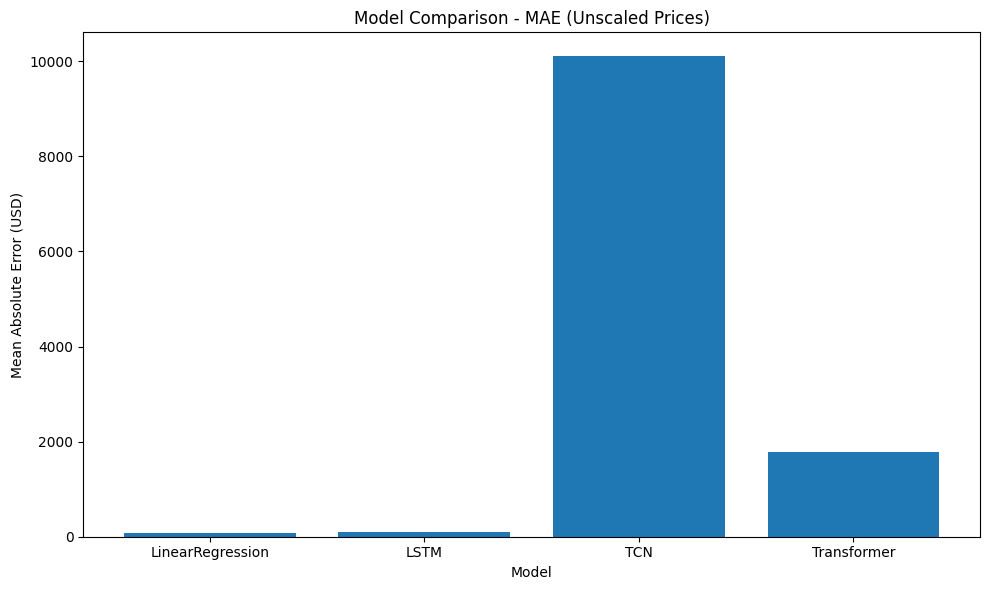

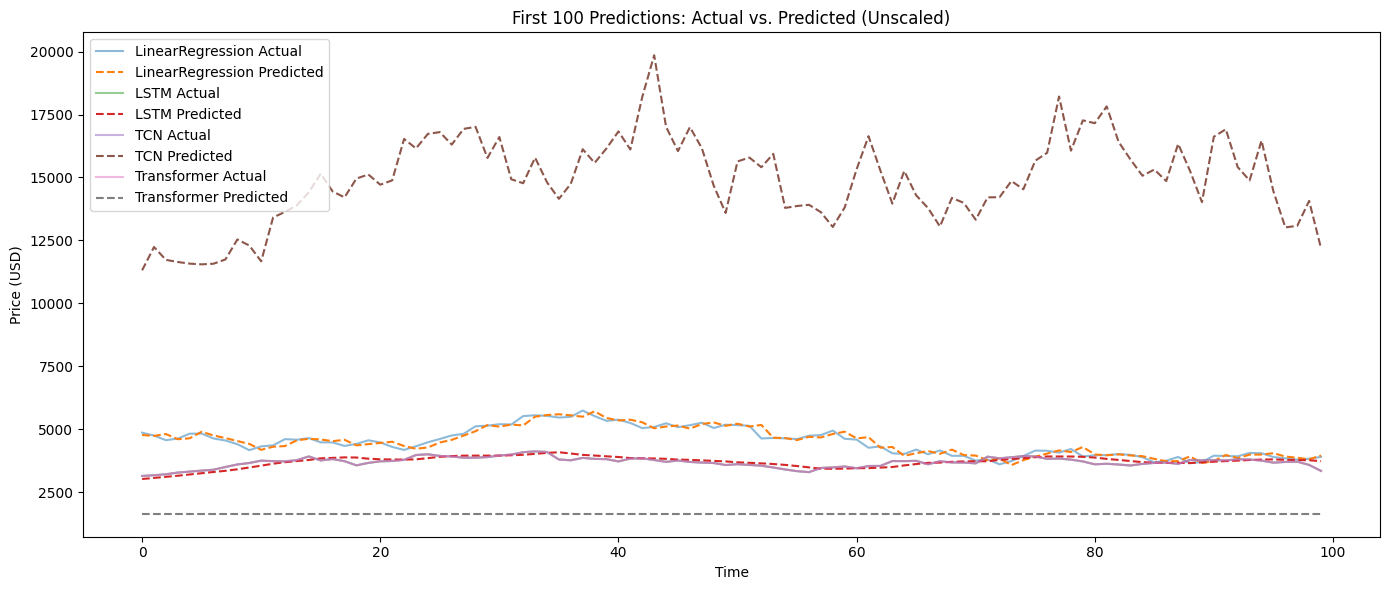

In [38]:
# Evaluation and plotting
models = {
    'LinearRegression': lr_model,
    'LSTM': lstm_model,
    # 'CNN-LSTM': cnn_lstm_model,
    'TCN': tcn_model,
    # 'GRU': gru_model,
    'Transformer': transformer_model
}

results = {}
mae_scores = []
successful_models = []

print("Evaluating models...")
for name, model in models.items():
    try:
        if name == 'LinearRegression':
            y_pred = model.predict(X_test_lr)
            y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
            y_test_inv = scaler.inverse_transform(y_test_lr.reshape(-1, 1))
        else:
            y_pred = model.predict(X_test)
            y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        mae_scores.append(mae)
        successful_models.append(name)
        results[name] = (y_test_inv, y_pred_inv)
        print(f"{name} MAE: {mae:.5f}")
    except Exception as e:
        print(f"Error in {name}: {e}")

# Save predictions
for name in results:
    pd.DataFrame({
        'Actual': results[name][0].flatten(),
        'Predicted': results[name][1].flatten()
    }).to_csv(f"{name}_predictions.csv", index=False)

# Save MAE scores
pd.DataFrame({'Model': successful_models, 'MAE': mae_scores}).to_csv("model_mae_scores.csv", index=False)

# Plot MAE comparison
plt.figure(figsize=(10, 6))
plt.bar(successful_models, mae_scores)
plt.title("Model Comparison - MAE (Unscaled Prices)")
plt.ylabel("Mean Absolute Error (USD)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# Overlay prediction plots
plt.figure(figsize=(14, 6))
for name in results:
    plt.plot(results[name][0][:100], label=f'{name} Actual', alpha=0.5)
    plt.plot(results[name][1][:100], label=f'{name} Predicted', linestyle='--')
plt.title("First 100 Predictions: Actual vs. Predicted (Unscaled)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()



[*********************100%***********************]  1 of 1 completed

Creating backtest + prediction overlay plot...


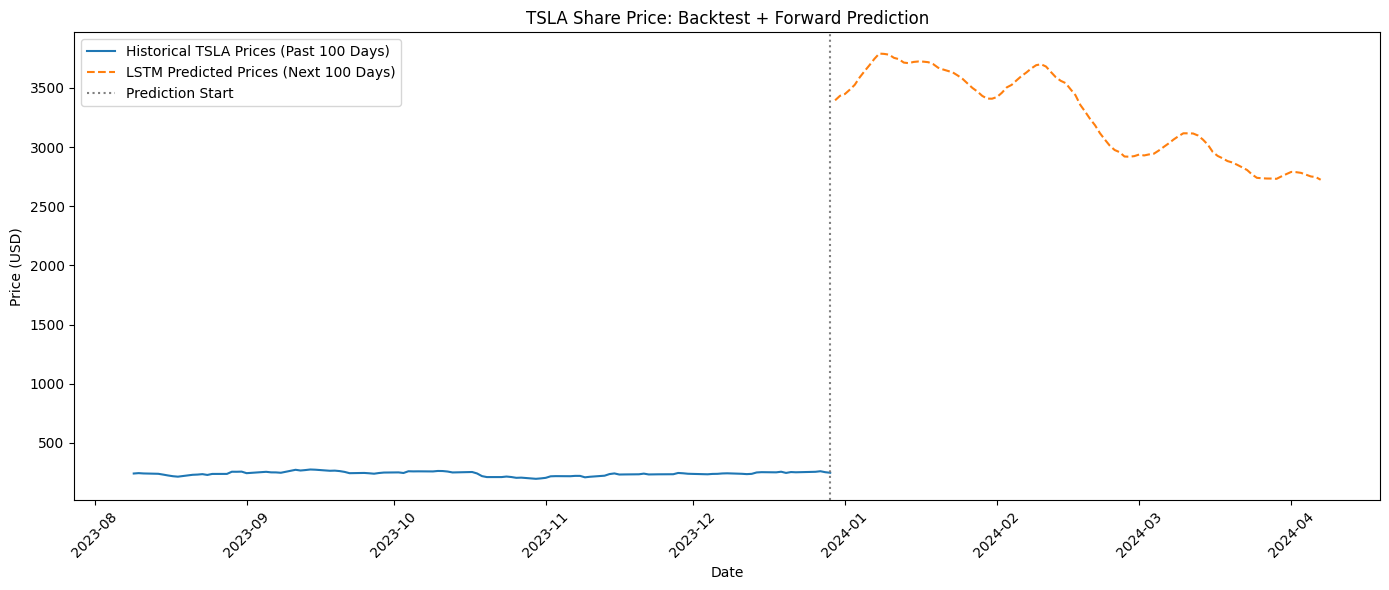

In [29]:
# Backtest + Prediction Overlay Plot
print("Creating backtest + prediction overlay plot...")
selected_model = "LSTM"
try:
    preds_df = pd.read_csv(f"{selected_model}_predictions.csv")
    tsla_raw = yf.download("TSLA", start="2010-01-01", end="2023-12-31")[['Close']].dropna()
    tsla_raw.reset_index(inplace=True)
    tsla_raw.sort_values(by='Date', inplace=True)

    # Use last 100 actual prices + first 100 predictions
    backtest_actual = tsla_raw['Close'].values[-100:]
    predicted_forward = preds_df['Predicted'].values[:100]
    backtest_dates = tsla_raw['Date'].values[-100:]
    forward_dates = pd.date_range(start=tsla_raw['Date'].iloc[-1] + pd.Timedelta(days=1), periods=100)

    plt.figure(figsize=(14, 6))
    plt.plot(backtest_dates, backtest_actual, label='Historical TSLA Prices (Past 100 Days)')
    plt.plot(forward_dates, predicted_forward, label=f'{selected_model} Predicted Prices (Next 100 Days)', linestyle='--')
    plt.axvline(backtest_dates[-1], color='gray', linestyle=':', label='Prediction Start')
    plt.title("TSLA Share Price: Backtest + Forward Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot backtest overlay: {e}")